Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Activation,Dropout
from keras.layers import BatchNormalization
from glob import glob



In [2]:

from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration' 

## Ref took from :https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:


data_dir_train = pathlib.Path(root_path+"/Train/")
data_dir_test = pathlib.Path(root_path+"/Test/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

## Reference took from tensorflow documentation for training dataset and validation dataset

train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
    shuffle=True, seed=123, validation_split=0.2, subset="training",
    interpolation='bilinear', follow_links=False
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds= tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
    shuffle=True, seed=123, validation_split=0.2, subset="validation",
    interpolation='bilinear', follow_links=False
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

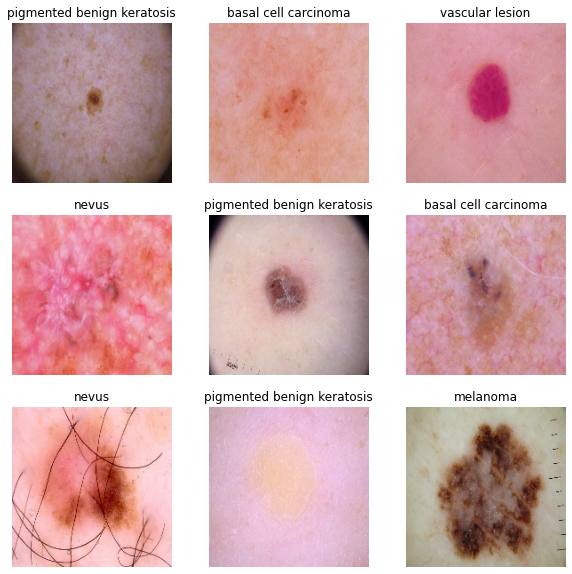

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:

### Your code goes here

num_classes = 9
# model architecture

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0

In [15]:
### Compiling / Building the model


model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 374s 4s/step - loss: 3.0299 - accuracy: 0.1818 - val_loss: 1.8277 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 77s 1s/step - loss: 1.8375 - accuracy: 0.3326 - val_loss: 1.6369 - val_accuracy: 0.4787
Epoch 3/20
56/56 [==============================] - 77s 1s/step - loss: 1.6006 - accuracy: 0.4616 - val_loss: 1.5185 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 77s 1s/step - loss: 1.4345 - accuracy: 0.5074 - val_loss: 1.4757 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 77s 1s/step - loss: 1.3288 - accuracy: 0.5120 - val_loss: 1.4947 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 77s 1s/step - loss: 1.2129 - accuracy: 0.5621 - val_loss: 1.4531 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 77s 1s/step - loss: 1.1245 - accuracy: 0.6010 - val_loss: 1.4495 - val_accuracy: 0.5280
Epoch 8/20
56/56 [=

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0

### Visualizing training results

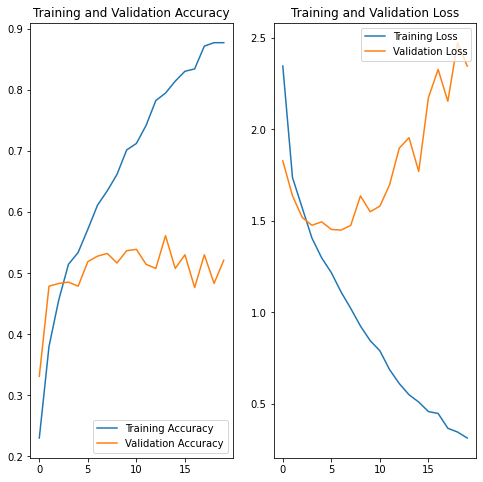

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Analysis From First model**


Training Accuracy goes above 80% and Validation Accuracy goes upto 50%


Looks like this model is completely overfitted, We will try to augmentation for reducing such errors.


In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# Stratergy:- We will be using augmentation with the help of tensorflow -  Make the preprocessing layers part of your model
# Benefits for this approach :- Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
# When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.


IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])





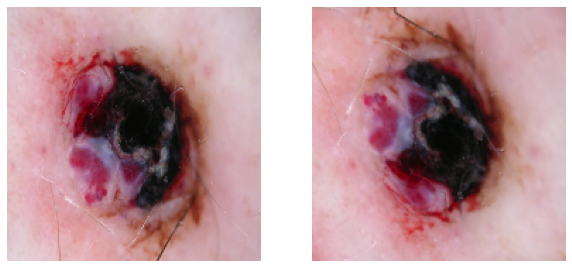

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
fig=plt.figure(figsize=(10, 10))

 
for images, labels in train_ds.take(1):
  for i in range(1):
    fig.add_subplot(1, 2, 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    image = tf.expand_dims(images[i].numpy().astype("uint8"), 0)
    augmented_image = data_augmentation(image)
    fig.add_subplot(1, 2, 2)
    plt.imshow(augmented_image[0])
    plt.axis("off")




### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Model 2 - With Dropout

num_classes = 9
# model architecture

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


### Compiling the model

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
activation_4 (Activation)    (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 90, 90, 64)       

In [23]:
## Your code goes here
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 85s 2s/step - loss: 4.6394 - accuracy: 0.1829 - val_loss: 2.1031 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 83s 1s/step - loss: 2.0447 - accuracy: 0.2466 - val_loss: 1.9634 - val_accuracy: 0.3803
Epoch 3/20
56/56 [==============================] - 83s 1s/step - loss: 1.9180 - accuracy: 0.3204 - val_loss: 1.8107 - val_accuracy: 0.4094
Epoch 4/20
56/56 [==============================] - 83s 1s/step - loss: 1.8113 - accuracy: 0.3440 - val_loss: 1.7418 - val_accuracy: 0.4430
Epoch 5/20
56/56 [==============================] - 84s 1s/step - loss: 1.7127 - accuracy: 0.3779 - val_loss: 1.6362 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 83s 1s/step - loss: 1.6403 - accuracy: 0.3955 - val_loss: 1.5692 - val_accuracy: 0.4676
Epoch 7/20
56/56 [==============================] - 83s 1s/step - loss: 1.5881 - accuracy: 0.4250 - val_loss: 1.5273 - val_accuracy: 0.5123
Epoch 8/20
56/56 [==

### Visualizing the results

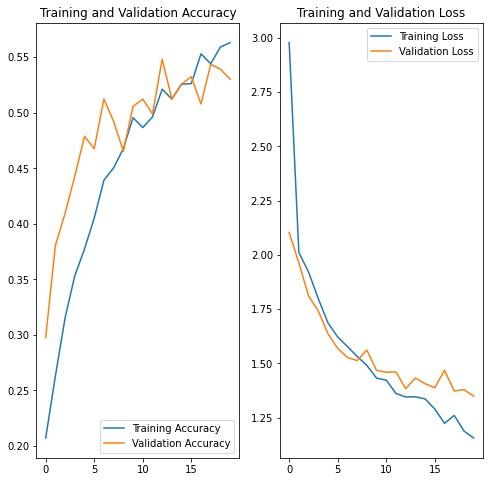

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis on 2nd Model

Looks Like Droupouts has been significant improvement for model to learn, still we need to tune some hyperparameters

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
## Checking the class distribution with number of samples in each classes (UNIT Wise)


print("Number of samples in each classes are :- \n")
for x in class_names:
  # Google Drive created '.DS_Store' for some reasons, and we do not need to consider for our analysis
  if(x !='.DS_Store'):
    number_of_items=len(list(pathlib.Path(data_dir_train, str(x)).glob('*.jpg')))
    print(str(x) + ": "+ str(number_of_items))



Number of samples in each classes are :- 

actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


- Which class has the least number of samples?
  
   Ans:- **seborrheic keratosis** has least number of samples 
   
   
   
- Which classes dominate the data in terms proportionate number of samples?
   
   Ans:- **pigmented benign keratosis**  dominates with highest samples with ***462*** samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) +"/"+ str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1030458E90>: 100%|██████████| 500/500 [00:22<00:00, 22.61 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F102FF09D90>: 100%|██████████| 500/500 [00:22<00:00, 22.19 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F104A33C910>: 100%|██████████| 500/500 [00:23<00:00, 21.57 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1035595E90>: 100%|██████████| 500/500 [01:53<00:00,  4.42 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1031078410>: 100%|██████████| 500/500 [01:34<00:00,  5.27 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1034452F10>: 100%|██████████| 500/500 [00:22<00:00, 22.07 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1031204F90>: 100%|██████████| 500/500 [00:50<00:00,  9.87 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F102FF1C850>: 100%|██████████| 500/500 [00:22<00:00, 21.87 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1035595A90>: 100%|██████████| 500/500 [00:22<00:00, 22.06 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [34]:
new_df['Label'].value_counts()

dermatofibroma                500
pigmented benign keratosis    500
squamous cell carcinoma       500
seborrheic keratosis          500
basal cell carcinoma          500
nevus                         500
vascular lesion               500
melanoma                      500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180


#### **Todo:** Create a training dataset

In [36]:
data_dir_train=pathlib.Path(root_path+"/Train/")
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
    shuffle=True, seed=123, validation_split=0.2, subset="training",
    interpolation='bilinear', follow_links=False
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds= tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
    shuffle=True, seed=123, validation_split=0.2, subset="validation",
    interpolation='bilinear', follow_links=False
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## Your code goes here
## Model 3 - Without Dropout

num_classes = 9

# model architecture
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(img_height,img_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 45, 64)       

#### **Todo:**  Train your model

In [41]:
epochs = 30
## Your code goes here, use 50 epochs.
history =history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
169/169 [==============================] - 271s 2s/step - loss: 2.3937 - accuracy: 0.2461 - val_loss: 1.6783 - val_accuracy: 0.3838
Epoch 2/30
169/169 [==============================] - 271s 2s/step - loss: 1.4510 - accuracy: 0.4567 - val_loss: 1.3627 - val_accuracy: 0.5033
Epoch 3/30
169/169 [==============================] - 270s 2s/step - loss: 1.2078 - accuracy: 0.5573 - val_loss: 1.0939 - val_accuracy: 0.5902
Epoch 4/30
169/169 [==============================] - 270s 2s/step - loss: 0.9752 - accuracy: 0.6492 - val_loss: 1.0734 - val_accuracy: 0.6177
Epoch 5/30
169/169 [==============================] - 270s 2s/step - loss: 0.8003 - accuracy: 0.7225 - val_loss: 1.0307 - val_accuracy: 0.6503
Epoch 6/30
169/169 [==============================] - 275s 2s/step - loss: 0.6102 - accuracy: 0.7929 - val_loss: 0.9273 - val_accuracy: 0.6659
Epoch 7/30
169/169 [==============================] - 273s 2s/step - loss: 0.5531 - accuracy: 0.8091 - val_loss: 0.8328 - val_accuracy: 0.7209

#### **Todo:**  Visualize the model results

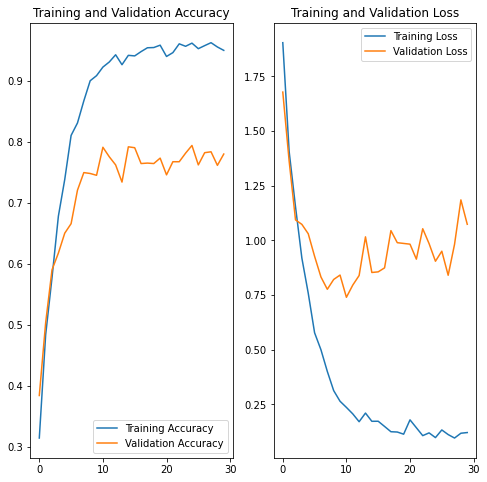

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### 30 Epochs clearly overfits the data for training dataset,

#### According to graph around 7 epochs provide much better result in accuracy as well as loss 
#### After implementing augmentation and dropouts , still we are facing overfitting,
#### However we can achieve a valid models by reducing size of epoch from 30 to 7(approx) (Assumptions) 


#### We can bring down overfit by adding more samples to train set, but in this scenario, it will overfit aswell 
#### with more samples as sample's dimensions and angles are restricted or limited

## Summary:- 

###  - Here more number of epochs overfits the data 
###  - We will need more samples in classes with different dimentions to reduce overfit. 
###  - We cannot compromise on accuracy as this dataset is of cancer, so accuracy is much more important factor 
